# 🎯 インタビュー分析レポート生成ツール

このノートブックは、複数のインタビューセッションを横断的に分析し、集約レポートを生成します。

**元のTypeScriptコード:** `20251123_test-format4-ai-plan-hypothesis.ts`

---
# 🎓 このノートブックの使い方

## ステップ1: APIキーの設定 🔑

Google API Keyの設定が必要です。詳細は後述の「 🔑Gemini用のAPIキーを取得する」セルを参照してください。

---

## ステップ2: セルを順番に実行 ▶️

1. **📦 環境セットアップ** → ライブラリをインストール
2. **📁 CSVファイルのアップロード** → APIキー設定とデータアップロード
3. **⚙️ 設定パラメータ** → モデル、処理モード、バッチサイズなどを設定
4. **📝 プロンプトテンプレート** (2つのセル) → 必要なら編集
   - Sequential用プロンプト（初回生成・更新）
   - Parallel用プロンプト（バッチ分析・マージ）
5. **🛠️ ヘルパー関数** → データ処理関数を定義
6. **🔄 処理モード関数** → Sequential/Parallel処理ロジックを定義
7. **▶️ メイン実行** → 実際の分析を実行
   - CSV読み込み
   - セッション抽出とバッチ分割
   - 選択した処理モードで分析実行
   - レポート生成と保存

---

## ステップ3: 処理モードの選択 🔄

**Sequential モード（逐次処理）**
- セッションを1つずつ処理
- レポートを段階的に更新
- メモリ使用量が少ない
- 処理時間は長め

**Parallel モード（並列処理）**
- バッチごとに並列で分析
- 最後に全バッチをマージ
- 処理時間が短い
- より大規模なデータに対応

---

## ステップ4: プロンプトのカスタマイズ（オプション）✏️

プロンプトテンプレートのセルを直接編集できます：

- **Sequential用**: 初回生成・更新用の2つのプロンプト
- **Parallel用**: バッチ分析・マージ用の2つのプロンプト

編集後、そのセルを再実行してください。

---

## トラブルシューティング 🔧

### APIキーエラー
```
❌ Google API Key の取得に失敗しました
```
→ Secrets に `GOOGLE_API_KEY` が登録されているか確認

### CSVファイルが見つからない
```
⚠️ CSVファイルが見つかりません
```
→ `MESSAGES_CSV_PATH` のパスを修正

### メモリ不足・トークン制限
→ `TOKENS_PER_BATCH` を小さくする、または `MIN_MESSAGES` を増やしてセッション数を減らす

---

**準備ができたら、次のセルから順番に実行してください！** 🚀


In [ ]:
#@title 📦 環境セットアップ

# インポート
import google.generativeai as genai
import pandas as pd
import json
import os
from datetime import datetime
from typing import List, Dict, Any
from google.colab import files, userdata
import time
from IPython.display import display, HTML, Markdown

print("✅ モジュールのインポート完了")

✅ モジュールのインポート完了


In [ ]:
#@title 📁 bill-of-lading_messages.csv のアップロード

#@markdown 以下の3つの方法から選んでください：

upload_method = "アップロード" #@param ["アップロード", "Google Drive", "すでに配置済み"]

if upload_method == "アップロード":
    print("📤 CSVファイルをアップロードしてください...")
    uploaded = files.upload()

    # data/ ディレクトリを作成
    os.makedirs('/content/data', exist_ok=True)

    # アップロードされたファイルを保存
    for filename in uploaded.keys():
        if 'messages' in filename:
            target_path = f'/content/data/{filename}'
            with open(target_path, 'wb') as f:
                f.write(uploaded[filename])
            print(f"✅ {target_path} に保存しました")

elif upload_method == "Google Drive":
    from google.colab import drive

    print("📂 Google Drive をマウント中...")
    drive.mount('/content/drive')

    print("✅ マウント完了")
    print("💡 次のセルで MESSAGES_CSV_PATH を正しいパスに修正してください")
    print("   例: /content/drive/MyDrive/data/bill-of-lading_messages.csv")

else:
    print("✅ ファイルがすでに配置されていることを前提とします")
    print("💡 次のセルで MESSAGES_CSV_PATH が正しいか確認してください")

📤 CSVファイルをアップロードしてください...


Saving bill-of-lading_messages.csv to bill-of-lading_messages.csv
✅ /content/data/bill-of-lading_messages.csv に保存しました


# 🔑Gemini用のAPIキー （直接サーバーとやりとりしてAIを動かすためのパスワードのようなもの）を取得する
- Google AI Studioにアクセス： お手持ちのGoogleアカウントで[Google AI Studioの公式サイト](https://aistudio.google.com/)にログインします。
- terms of serviceを確認して、同意
- 「Get API key」をクリック： 画面の左側サイドバーの下部に「Get API key（APIキーを取得）」というメニュー項目がありますので、これをクリックします。
-
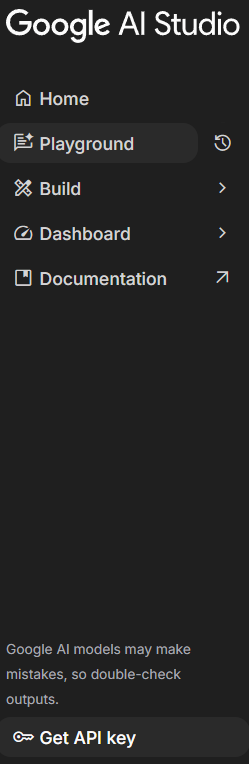

- APIキーを作成： 「Create API key in new project（新しいプロジェクトでAPIキーを作成）」ボタンを押します。
- キーをコピーして保存： すぐにAPIキー（長い文字列）が生成されます。

# 🔑 API設定
- 左サイドバーの鍵アイコン → `Gemini API キー` をクリック
- Google AI Studioからキーをインポート

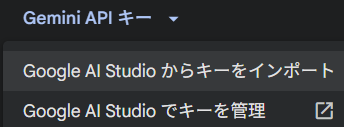

- 該当するAPIキーを選んで、右下のインポートボタンをクリック

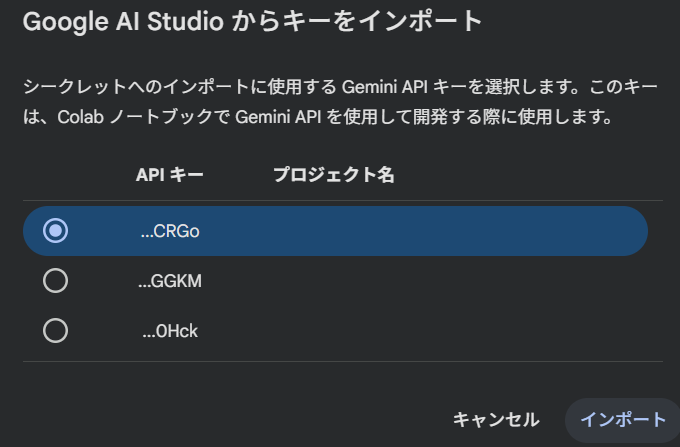

In [ ]:
#@title ⚙️ 設定パラメータ（変更はしなくてOK）

from google.colab import userdata




try:
    GOOGLE_API_KEY = userdata.get('GEMINI_API_KEY')
    print("✅ Google API Key を Colab Secrets から取得しました")
except Exception as e:
    print("❌ GEMINI API Key の取得に失敗しました")
    print("💡 左サイドバーの🔑アイコンから 'GEMINI_API_KEY' を登録してください")
    raise e

#@markdown ---
#@markdown ### 🤖 モデル設定
#@markdown **どのAIモデルを使うかを選びます。性能やコストが変わります。**
#@markdown **Gemini-3-proにすると、無料のAPIキーの場合、単位時間に処理可能な情報量を超えて途中で止まる可能性があります。**
MODEL_NAME = "gemini-flash-lite-latest" #@param ["gemini-flash-lite-latest", "gemini-flash-latest"","gemini-3-pro-preview", "gemini-2.0-flash-exp", "gemini-1.5-pro", "gemini-1.5-flash"] {allow-input: true}
#@markdown **AIが生成するレポートの最大の長さを決めます。値が大きいほど長いレポートが作成できます。**
MAX_OUTPUT_TOKENS = 64000 #@param {type:"integer"}
#@markdown **AIの創造性（ランダム性）を調整します。値が低いほど厳密で、高いほど自由な発想のレポートになります。Proの場合は1が推奨されてます。**
TEMPERATURE = 0.3 #@param {type:"slider", min:0, max:1, step:0.1}

#@markdown ---
#@markdown ### 📂 データ設定
#@markdown **分析するインタビューを識別するための短い名前です。CSVファイル名にも使われます。**
slug = "bill-of-lading" #@param {type:"string"}

#@markdown **インタビューの会話データが入っているCSVファイルの場所（パス）を指定します。**
MESSAGES_CSV_PATH = "/content/data/bill-of-lading_messages.csv" #@param {type:"string"}
#@markdown ↑ messages.csv のパス

#@markdown ---
#@markdown ### 🔄 処理モード
#@markdown **AIがレポートを生成する際の処理方法を選びます。**
mode = "parallel" #@param ["sequential", "parallel"]
#@markdown - **sequential**: 逐次処理（バッチを1つずつ処理）
#@markdown   **セッションデータを順番に少しずつ処理して、レポートを段階的に完成させます。**
#@markdown - **parallel**: 並列処理（全バッチ同時処理後にマージ）
#@markdown   **すべてのセッションデータを一度にAIに渡し、まとめてレポートを作成します。複数のセッションを一度に見て全体を把握するのに適しています。**

#@markdown ---
#@markdown ### ⚡ バッチ設定
#@markdown **AIが一度に処理できる情報の量（トークン数）の目安です。あまり大きくしすぎるとエラーになることがあります。**
TOKENS_PER_BATCH = 700000 #@param {type:"integer"}
#@markdown **プロンプトテンプレート自体が消費する情報の量（トークン数）の目安です。AIへの指示文の長さにかかる負荷です。**
ESTIMATED_PROMPT_OVERHEAD = 100000 #@param {type:"integer"}

#@markdown ---
#@markdown ### 📝 メモ（オプション）
#@markdown **今回の分析に関するメモを自由に残せます。レポートには影響しません。**
memo = "" #@param {type:"string"}

# ファイル存在確認
import os
if os.path.exists(MESSAGES_CSV_PATH):
    print(f"✅ CSVファイルが見つかりました: {MESSAGES_CSV_PATH}")
else:
    print(f"⚠️  CSVファイルが見つかりません: {MESSAGES_CSV_PATH}")
    print("💡 ファイルをアップロードするか、パスを修正してください")

print("\n📋 設定内容:")
print(f"   モデル: {MODEL_NAME}")
print(f"   Slug: {slug}")
print(f"   モード: {mode}")
print(f"   温度: {TEMPERATURE}")

✅ Google API Key を Colab Secrets から取得しました
✅ CSVファイルが見つかりました: /content/data/bill-of-lading_messages.csv

📋 設定内容:
   モデル: gemini-flash-lite-latest
   Slug: bill-of-lading
   モード: parallel
   温度: 0.3


In [ ]:
#@title 📋 インタビューメタデータ設定（編集可能）

#@markdown プロンプトに埋め込まれるメタデータです。実際のインタビュー内容に合わせて編集してください。

interviewTitle = "国際貿易における「船荷証券」の電子化法案" #@param {type:"string"}
interviewDescription = "国際海上輸送において用いられる船荷証券を電子的に取り扱うことを可能とし、従来の紙媒体と同等の法的効力を付与する法案" #@param {type:"string"}
interviewOverview = "本法案は貿易取引の迅速化・効率化を図るとともに、偽造・紛失リスクを低減し、国際的な制度との整合性を確保することを目的としています。なお、本法案は電子化を「義務づける」ものではなく、紙と電子のいずれかを選択できる制度を整備するものです。" #@param {type:"string"}

#@markdown 詳細の設定にはこのセルをダブルクリック、主なテーマ、質問、コンテキストといった設定が可能
### 主なテーマ
interviewThemes = """1. 電子船荷証券を法的に承認し、紙と同等の効力を持たせる
2. 電子的な方法での権利移転や担保設定を可能にする
3. 紙と電子を相互に切り替えられる仕組みを整備する
4. 国際的なルール（UNCITRALモデル法）との調和を図る"""

### インタビューで扱った質問
interviewQuestions = """Q1. 効率化 vs 導入コスト
- 期待される効果: 電子裏書によって即時に権利移転が可能となり、貨物引渡しや金融取引が迅速化。保証状発行の回避でコスト削減も見込める
- 懸念: 中小事業者にとってはシステム導入費用や運用教育コストが負担となり、利用格差を広げる懸念

Q2. セキュリティ向上 vs サイバーリスク
- 期待される効果: ブロックチェーンなどの技術により改ざんや偽造リスクは低下し、紙よりも安全性は高まる
- 懸念: サイバー攻撃やシステム障害によって、広範囲の物流が同時に停止するリスクが新たに生じる

Q3. 国際標準化への適応 vs 国内事業者の負担
- 期待される効果: UNCITRALモデル法に準拠し国際整合性を確保することで、日本企業の国際競争力が維持できる
- 懸念: 国内の商慣行や既存システムに合わせるための調整や、導入・適合に伴う初期コストが発生"""

### 参考知識・コンテキスト
knowledgeContext = """法改正が必要な理由:
- 紙の船荷証券は国際郵送に数日を要し、貨物が到着しても引き渡しが遅れるケースが多発
- 紙は紛失や偽造といったリスクが高く、保証状（L/G）や保険のコストが商品価格に転嫁され取引コスト上昇の要因
- 世界的には電子化の制度整備が進展しており、日本が遅れれば国際取引における競争上の不利を招く

影響を受けるステークホルダー:
- 海運会社・大手商社: 国際取引の効率化が進むが、複数システム間の相互運用性確保が課題
- 中小輸出入業者: 業務効率化の恩恵を受ける一方で、導入コストやIT習熟の負担が生じる
- 金融機関・保険会社: 担保設定や信用状処理が迅速化し業務効率は改善するが、サイバーリスク管理への追加投資が必要
- 消費者: 物流効率化による価格安定効果が見込まれるが、システム障害時には供給停滞リスクあり"""

# メタデータ辞書を作成
interview_metadata = {
    "interviewTitle": interviewTitle,
    "interviewDescription": interviewDescription,
    "interviewOverview": interviewOverview,
    "interviewThemes": interviewThemes,
    "interviewQuestions": interviewQuestions,
    "knowledgeContext": knowledgeContext
}

print("✅ インタビューメタデータ設定完了")
print(f"\nタイトル: {interviewTitle}")
print(f"説明: {interviewDescription}")

✅ インタビューメタデータ設定完了

タイトル: 国際貿易における「船荷証券」の電子化法案
説明: 国際海上輸送において用いられる船荷証券を電子的に取り扱うことを可能とし、従来の紙媒体と同等の法的効力を付与する法案


In [ ]:
#@title 📝 プロンプト1: 初回レポート生成（編集可能）

INITIAL_PROMPT_TEMPLATE = """あなたは法案に関する市民との対話セッションを分析し、横断的な考察を行う専門家です。
下記の情報を元に、対話セッションのまとめレポートを作成してください。

## 法案の背景

以下は「{{interviewTitle}}」というテーマで実施された対話セッションの分析依頼です。

【法案の概要】
{{interviewDescription}}

{{interviewOverview}}

【主なポイント】
{{interviewThemes}}

【対話で扱った質問】
{{interviewQuestions}}

【参考情報・詳細】
{{knowledgeContext}}

この対話は上記の背景、質問、参考情報に基づいて実施されました。この文脈を踏まえて、以下のセッションデータを分析してください。

---

## あなたのタスク

下記の対話セッション（{{sessionCount}}セッション）を横断的に分析し、法案に対する市民の意見、懸念、提案、質問などを整理してMarkdownレポートを生成してください。

注意: これは初回レポート生成です。後ほど追加のセッションデータを統合する予定なので、現時点でのデータに基づいた分析を提供してください。

## 出力フォーマット

# {{interviewTitle}} - 市民対話レポート

## まとめ

[全体を通じて見えてきた主要なテーマ、パターン、重要な発見を2-3段落で要約してください。]

## 主要な論点

### 論点1: [法案に対する主要な論点名]

#### 賛成意見・期待される効果
- [意見1]
- [意見2]

#### 懸念・反対意見
- [懸念1]
- [懸念2]

#### 提案・アイデア
- [提案1]
- [提案2]

### 論点2: [法案に対する主要な論点名]

[同様に、対話から抽出された主要な論点ごとに章立てして分析結果を記述してください]

## よくある質問と市民の疑問

[対話セッションで頻繁に出た質問や疑問点をまとめてください]

## 影響を受けるステークホルダーの視点

[異なるステークホルダー（事業者、消費者、行政など）の視点から見た意見をまとめてください]

---

重要な注意事項:
1. Markdownフォーマットで出力してください
2. HTMLタグは使用しないでください
3. 太字マークダウン（アスタリスク2つ）は使用しないでください。日本語では括弧の処理がうまくいかないことが多いためです
4. 前置きや説明は不要で、「# {{interviewTitle}} - 市民対話レポート」から始めてください
5. 具体的な発言を引用する場合は、必ず「#」を付けたセッション番号で出典を明記してください
6. 個々のセッションの要約ではなく、横断的な分析に焦点を当ててください
7. 【重要】対話参加者の生の声を積極的に引用してください。「\"発言内容\"(#セッション番号)」の形式で多数引用することで、リアリティと説得力のあるレポートにしてください
8. 【重要】対話参加者の数量的情報や量的表現は一切含めないでください。以下のような表現は使用禁止です：
   - 禁止例: 「多くの参加者が」「一部の人が」「ほとんどの人が」「大半が」「少数だが」
   - 推奨: 「ある参加者は」「〜という意見がある」「〜という視点も示された」など
9. 【重要】価値判断や評価を含む表現を避けてください。以下のような表現は使用禁止です：
   - 禁止例: 「さらに踏み込み」「より高度な」「深い洞察」「優れた提案」「重要度が高い」
   - 推奨: 「〜という意見がある」「〜という視点も示された」など、中立的な記述を使用
10. 【重要】レトリックや主観的な修飾語を排除し、学術論文のように客観的かつ簡潔に記述してください
11. 【重要】表面的な議論にとどまらないように、意見に対する反論や再反論なども積極的に構造化しながら取り上げてください
12. {{outputLengthGuidance}}

---

## セッションデータ ({{sessionCount}}セッション)

{{sessionsData}}
"""

print(f"✅ INITIAL_PROMPT_TEMPLATE 読み込み完了 ({len(INITIAL_PROMPT_TEMPLATE):,} 文字)")

✅ INITIAL_PROMPT_TEMPLATE 読み込み完了 (1,790 文字)


In [ ]:
#@title 📝 プロンプト2: 更新プロンプト（編集可能）

UPDATE_PROMPT_TEMPLATE = """あなたは複数のインタビューセッションを分析し、横断的な考察を行う専門家です。

## タスク概要

以前に作成した集約レポートに、**追加のセッションデータ（{{newSessionCount}}セッション）を統合**して、レポートを更新してください。

**重要**: 最終的なレポートには、どのデータが「新しく追加された」か、「前回のレポートから」といった記述は一切含めないでください。すべてのセッションを一度に分析したかのように、一つの統合されたレポートとして出力してください。

## インタビューの背景

以下は「{{interviewTitle}}」というテーマで実施されたインタビューの分析です。

【説明】
{{interviewDescription}}

【概要】
{{interviewOverview}}

【主なテーマ】
{{interviewThemes}}

【インタビューで扱った質問】
{{interviewQuestions}}

【参考知識・コンテキスト】
{{knowledgeContext}}

---

## 前回のレポート

以下は、これまでに分析したセッションから作成したレポートです：

{{previousReport}}

---

## 新しいセッションデータ ({{newSessionCount}}セッション)

以下の新しいセッションを分析し、上記のレポートに統合してください：

{{sessionsData}}

---

## あなたのタスク

1. 追加のセッションデータを分析し、前回のレポートに含まれていない発見、視点、パターンを特定してください
2. 前回のレポートを更新してください：
   - 新しい発見があれば、該当するカテゴリに追加
   - 新しいカテゴリが必要であれば追加
   - 既存の記述が追加データで補強される場合は、引用を追加
   - 「まとめ」セクションも追加データを反映して更新
3. 前回のレポートの良い部分は維持してください（不要な削除や書き換えは避ける）

**絶対に守るべきルール:**
- 「新たなセッションデータにより」「追加のデータから」「前回のレポートでは」といった、分析プロセスを示唆する表現は一切使用しないでください
- 「より具体的な」「さらに詳細な」など、レポートの更新履歴を示す表現も避けてください
- すべてのセッションを最初から一度に分析したかのように記述してください
- 引用を追加する場合も、必ず「#」を付けたセッション番号で出典を明記してください
- 前回のレポートの構造とスタイルを維持してください
- 前置きや説明は不要で、更新された「# {{interviewTitle}} - 集約レポート」を直接出力してください

注意事項:
1. Markdownフォーマットで出力してください
2. HTMLタグは使用しないでください
3. 太字マークダウン（アスタリスク2つ）は使用しないでください。日本語では括弧の処理がうまくいかないことが多いためです
4. 具体的な発言を引用する場合は、必ず「#」を付けたセッション番号で出典を明記してください
5. 【重要】インタビュー参加者の生の声を積極的に引用してください。「\"発言内容\"(#セッション番号)」の形式で引用してください
6. 【重要】数量的情報や量的表現は一切含めないでください (「多くの参加者が」「一部の人が」など禁止)
7. 【重要】価値判断や評価を含む表現を避けてください (「深い洞察」「優れた提案」など禁止)
8. 【重要】レトリックや主観的な修飾語を排除し、学術論文のように客観的かつ簡潔に記述してください
9. {{outputLengthGuidance}}

---

更新されたレポートを出力してください：
"""

print(f"✅ UPDATE_PROMPT_TEMPLATE 読み込み完了 ({len(UPDATE_PROMPT_TEMPLATE):,} 文字)")

✅ UPDATE_PROMPT_TEMPLATE 読み込み完了 (1,616 文字)


In [ ]:
#@title 📝 プロンプト3: マージプロンプト（編集可能）

MERGE_PROMPT_TEMPLATE = """あなたは複数のインタビューセッションを分析し、横断的な考察を行う専門家です。

## タスク概要

複数のバッチに分けて並列に分析されたインタビューレポートを、**一つの統合されたレポート**にマージしてください。

## インタビューの背景

以下は「{{interviewTitle}}」というテーマで実施されたインタビューの分析です。

【説明】
{{interviewDescription}}

【概要】
{{interviewOverview}}

【主なテーマ】
{{interviewThemes}}

【インタビューで扱った質問】
{{interviewQuestions}}

【参考知識・コンテキスト】
{{knowledgeContext}}

---

## バッチレポート ({{batchCount}}個のレポート)

以下は、セッションを{{batchCount}}個のバッチに分けて並列に分析した結果です：

{{batchReports}}

---

## あなたのタスク

上記の{{batchCount}}個のレポートを統合し、一つの包括的な集約レポートを作成してください。

**重要な注意事項:**
1. **情報の完全保持**: マージ前のレポートにあった情報を失わないでください。すべての重要な発見、指摘、引用を統合レポートに含めてください
2. **生の引用をそのまま引き継ぐ**: 各バッチレポートに含まれる具体的な発言の引用は、セッション番号とともにそのまま統合レポートに含めてください
3. **重複の排除**: 複数のバッチで同じ発見や意見が記載されている場合のみ、一度だけ記載してください。ただし引用は異なるセッションからのものであれば複数残してください
4. **カテゴリの再構成**: バッチごとのカテゴリを見直し、より適切な分類に再構成してください
5. **網羅性の確保**: すべてのバッチから重要な発見を漏らさず含めてください。マージ前のレポートで言及されていた論点や視点がすべて統合レポートに反映されているか確認してください
6. **一貫性の維持**: トーンやスタイルを統一し、一つのレポートとして自然に読めるようにしてください
7. **文字数について**: 情報を保持するために文字数が増えることは問題ありません。包括的で詳細なレポートを作成してください

**絶対に守るべきルール:**
- 「バッチ1では」「バッチ2の分析によると」といった、バッチ分割を示唆する表現は一切使用しないでください
- すべてのセッションを最初から一度に分析したかのように記述してください
- 引用する場合も、必ず「#」を付けたセッション番号で出典を明記してください
- Markdownフォーマットで出力してください
- HTMLタグは使用しないでください
- 太字マークダウン（アスタリスク2つ）は使用しないでください
- 前置きや説明は不要で、「# {{interviewTitle}} - 集約レポート」から始めてください
- 数量的情報や量的表現は一切含めないでください (「多くの参加者が」など禁止)
- 価値判断や評価を含む表現を避けてください (「深い洞察」など禁止)
- レトリックや主観的な修飾語を排除し、学術論文のように客観的かつ簡潔に記述してください
- {{outputLengthGuidance}}

## 出力フォーマット

# {{interviewTitle}} - 集約レポート

## まとめ

[全体を通じて見えてきた主要なテーマ、パターン、重要な発見を2段落で要約してください。]

## 仮説1: [事前に設定した仮説]

### 支持する意見
- [意見1]
- [意見2]

### 反論・異なる視点
- [反論1]
- [反論2]

### 検証結果
[この仮説に対する総合的な評価]

## 仮説2: [事前に設定した仮説]

[同様に、事前に設定した仮説ごとに章立てして検証結果を記述してください]

---

統合されたレポートを出力してください：
"""

print(f"✅ MERGE_PROMPT_TEMPLATE 読み込み完了 ({len(MERGE_PROMPT_TEMPLATE):,} 文字)")

✅ MERGE_PROMPT_TEMPLATE 読み込み完了 (1,737 文字)


In [ ]:
#@title 🛠️ ヘルパー関数定義

def configure_genai(api_key: str):
    """Google Generative AI の設定"""
    genai.configure(api_key=api_key)
    print("✅ Google Generative AI の設定完了")

def generate_text_with_gemini(
    model_name: str,
    prompt: str,
    temperature: float = 0.3,
    max_output_tokens: int = 64000,
    max_retries: int = 3,
    retry_delay: int = 5 # seconds
) -> Dict[str, Any]:
    """
    Google Generative AI SDK でテキスト生成

    Returns:
        {
            "text": str,  # 生成されたテキスト
            "usage": {    # トークン使用量
                "prompt_tokens": int,
                "completion_tokens": int,
                "total_tokens": int
            }
        }
    """
    model = genai.GenerativeModel(model_name)

    generation_config = genai.types.GenerationConfig(
        temperature=temperature,
        max_output_tokens=max_output_tokens,
    )

    for attempt in range(max_retries):
        try:
            response = model.generate_content(
                prompt,
                generation_config=generation_config
            )

            # トークン使用量の取得
            usage = {
                "prompt_tokens": response.usage_metadata.prompt_token_count,
                "completion_tokens": response.usage_metadata.candidates_token_count,
                "total_tokens": response.usage_metadata.total_token_count
            }

            return {
                "text": response.text,
                "usage": usage
            }
        except Exception as e:
            print(f"⚠️ API呼び出しでエラーが発生しました (試行 {attempt + 1}/{max_retries}): {e}")
            if attempt < max_retries - 1:
                print(f"   {retry_delay}秒後に再試行します...")
                time.sleep(retry_delay)
            else:
                print("❌ 最大再試行回数に達しました。処理を中断します。")
                raise e

def load_messages_csv(csv_path: str) -> pd.DataFrame:
    """messages.csv を読み込み"""
    print(f"📂 CSVファイルを読み込んでいます: {csv_path}")
    df = pd.read_csv(csv_path)
    print(f"✅ {len(df):,} 件のメッセージを読み込みました")
    print(f"📊 ユニークセッション数: {df['session_id'].nunique():,}")
    return df

def get_all_sessions(df: pd.DataFrame) -> List[str]:
    """
    DataFrameからすべてのユニークなsession_idを取得
    """
    return df['session_id'].unique().tolist()

def filter_sessions(
    df: pd.DataFrame,
    slug: str,
    min_messages: int = 7
) -> List[str]:
    """
    条件に合うセッションIDのリストを取得

    Args:
        df: messages DataFrame
        slug: インタビューのslug
        min_messages: 最小メッセージ数

    Returns:
        session_idのリスト（メッセージ数の降順）
    """
    # slugでフィルタリング（session_idにslugが含まれるもの）
    filtered = df[df['session_id'].str.contains(slug, na=False, regex=False)]

    # セッションごとのメッセージ数をカウント
    session_counts = filtered.groupby('session_id').size()

    # 最小メッセージ数でフィルタ
    valid_sessions = session_counts[session_counts >= min_messages]

    # メッセージ数の降順でソート
    sorted_sessions = valid_sessions.sort_values(ascending=False)

    print(f"\n📊 フィルタリング結果:")
    print(f"   総セッション数: {len(session_counts):,}")
    print(f"   有効セッション数（{min_messages}メッセージ以上）: {len(valid_sessions):,}")
    print(f"   除外されたセッション: {len(session_counts) - len(valid_sessions):,}")

    return sorted_sessions.index.tolist()

def get_session_data(df: pd.DataFrame, session_ids: List[str]) -> List[Dict]:
    """
    指定されたsession_idのメッセージを取得

    Returns:
        [
            {
                "id": "session-1",
                "sessionNumber": 1,
                "messages": [
                    {"role": "user", "content": "...", "timestamp": "..."},
                    ...
                ]
            },
            ...
        ]
    """
    sessions_data = []

    for idx, session_id in enumerate(session_ids):
        session_messages = df[df['session_id'] == session_id].sort_values('timestamp')

        messages = []
        for _, row in session_messages.iterrows():
            messages.append({
                "role": row['role'],
                "content": str(row['content']),
                "timestamp": str(row['timestamp'])
            })

        if len(messages) > 0:
            sessions_data.append({
                "id": session_id,
                "sessionNumber": idx + 1,
                "messages": messages
            })

    return sessions_data

def format_sessions_data(sessions: List[Dict]) -> str:
    """セッションデータをMarkdown形式にフォーマット"""
    formatted = []

    for session in sessions:
        messages_text = "\n\n".join([
            f"**{msg['role']}**: {msg['content']}"
            for msg in session['messages']
        ])

        formatted.append(
            f"### Session #{session['sessionNumber']}\n\n{messages_text}"
        )

    return "\n\n---\n\n".join(formatted)

def estimate_tokens(text: str) -> int:
    """トークン数の概算（1トークン ≈ 4文字）"""
    return len(text) // 4

def create_batches(
    session_ids: List[str],
    message_counts: Dict[str, int],
    tokens_per_batch: int,
    prompt_overhead: int
) -> List[List[str]]:
    """
    セッションをバッチに分割

    Args:
        session_ids: 全セッションIDのリスト（メッセージ数降順）
        message_counts: {session_id: message_count}
        tokens_per_batch: バッチあたりの目標トークン数
        prompt_overhead: プロンプトテンプレートのオーバーヘッド

    Returns:
        バッチのリスト [[session_id, ...], ...]
    """
    batches = []
    current_batch = []
    current_tokens = prompt_overhead

    for session_id in session_ids:
        message_count = message_counts.get(session_id, 0)
        estimated_session_tokens = message_count * 350  # 1メッセージあたり約350トークン

        if current_tokens + estimated_session_tokens > tokens_per_batch and current_batch:
            # 現在のバッチを確定し、新しいバッチを開始
            batches.append(current_batch)
            current_batch = [session_id]
            current_tokens = prompt_overhead + estimated_session_tokens
        else:
            current_batch.append(session_id)
            current_tokens += estimated_session_tokens

    if current_batch:
        batches.append(current_batch)

    print(f"\n📦 バッチ分割結果:")
    print(f"   総バッチ数: {len(batches)}")
    for i, batch in enumerate(batches):
        print(f"   バッチ {i+1}: {len(batch)} セッション")

    return batches

print("✅ ヘルパー関数の定義完了")

✅ ヘルパー関数の定義完了


In [ ]:
#@title 🔄 処理モード関数定義

# バッチ単位のリトライ設定
BATCH_MAX_RETRIES = 2   # 合計3回試行
BATCH_RETRY_DELAY = 15  # 秒

def call_batch_with_retry(fn, label: str):
    """バッチ処理のリトライラッパー"""
    for attempt in range(BATCH_MAX_RETRIES + 1):
        try:
            return fn()
        except Exception as e:
            if attempt == BATCH_MAX_RETRIES:
                print(f"❌ {label} が {BATCH_MAX_RETRIES + 1} 回の試行後に失敗しました: {e}")
                raise
            print(f"⚠️  {label} が失敗しました (試行 {attempt + 1}/{BATCH_MAX_RETRIES + 1}): {e}")
            print(f"   {BATCH_RETRY_DELAY}秒後に再試行します...")
            time.sleep(BATCH_RETRY_DELAY)

def process_sequential_mode(
    batches: List[List[str]],
    messages_df: pd.DataFrame,
    model_name: str,
    temperature: float,
    max_output_tokens: int,
    interview_metadata: Dict[str, str]
) -> str:
    """
    逐次処理モード: バッチを1つずつ処理
    """
    current_report = ""

    for batch_index, batch in enumerate(batches):
        is_first_batch = batch_index == 0

        print(f"\n{'='*60}")
        print(f"📦 バッチ {batch_index + 1}/{len(batches)} 処理中...")
        print(f"{'='*60}\n")

        # セッションデータ取得
        sessions_data = get_session_data(messages_df, batch)
        sessions_text = format_sessions_data(sessions_data)

        # プロンプト作成
        output_length_guidance = "Target output length: 10,000-20,000 characters per batch. Provide detailed analysis with extensive quotations."

        if is_first_batch:
            print("🤖 初回レポート生成中...")
            prompt = INITIAL_PROMPT_TEMPLATE
        else:
            print("🔄 レポート更新中...")
            prompt = UPDATE_PROMPT_TEMPLATE.replace('{{previousReport}}', current_report)
            prompt = prompt.replace('{{newSessionCount}}', str(len(sessions_data)))

        # メタデータを埋め込み
        for key, value in interview_metadata.items():
            prompt = prompt.replace(f"{{{{{key}}}}}", value)

        prompt = prompt.replace('{{sessionCount}}', str(len(sessions_data)))
        prompt = prompt.replace('{{sessionsData}}', sessions_text)
        prompt = prompt.replace('{{outputLengthGuidance}}', output_length_guidance)

        estimated_tokens = estimate_tokens(prompt)
        print(f"   推定入力トークン: {estimated_tokens:,}")
        print(f"   セッション数: {len(sessions_data)}")

        # API呼び出し（バッチ単位のリトライ付き）
        result = call_batch_with_retry(
            lambda: generate_text_with_gemini(
                model_name=model_name,
                prompt=prompt,
                temperature=temperature,
                max_output_tokens=max_output_tokens
            ),
            f"バッチ {batch_index + 1} LLM呼び出し (sequential)"
        )

        current_report = result['text']
        usage = result['usage']

        print(f"\n✅ バッチ {batch_index + 1} 完了!")
        print(f"   入力トークン: {usage['prompt_tokens']:,}")
        print(f"   出力トークン: {usage['completion_tokens']:,}")
        print(f"   合計トークン: {usage['total_tokens']:,}")
        print(f"   出力サイズ: {len(current_report):,} 文字")

    return current_report

def process_parallel_mode(
    batches: List[List[str]],
    messages_df: pd.DataFrame,
    model_name: str,
    temperature: float,
    max_output_tokens: int,
    interview_metadata: Dict[str, str]
) -> str:
    """
    並列処理モード: 全バッチを同時処理後にマージ
    """
    print("🚀 並列処理モード: 全バッチを処理中...\n")

    batch_reports = []

    # 各バッチを処理（実際にはColabでは順次実行だが、独立して処理）
    for batch_index, batch in enumerate(batches):
        print(f"\n{'='*60}")
        print(f"📦 バッチ {batch_index + 1}/{len(batches)} 処理中...")
        print(f"{'='*60}\n")

        # セッションデータ取得
        sessions_data = get_session_data(messages_df, batch)
        sessions_text = format_sessions_data(sessions_data)

        # プロンプト作成（常にINITIALテンプレート使用）
        output_length_guidance = "Target output length: 10,000-20,000 characters per batch. Provide detailed analysis with extensive quotations."

        prompt = INITIAL_PROMPT_TEMPLATE

        # メタデータを埋め込み
        for key, value in interview_metadata.items():
            prompt = prompt.replace(f"{{{{{key}}}}}", value)

        prompt = prompt.replace('{{sessionCount}}', str(len(sessions_data)))
        prompt = prompt.replace('{{sessionsData}}', sessions_text)
        prompt = prompt.replace('{{outputLengthGuidance}}', output_length_guidance)

        estimated_tokens = estimate_tokens(prompt)
        print(f"   推定入力トークン: {estimated_tokens:,}")
        print(f"   セッション数: {len(sessions_data)}")

        # API呼び出し（バッチ単位のリトライ付き）
        result = call_batch_with_retry(
            lambda: generate_text_with_gemini(
                model_name=model_name,
                prompt=prompt,
                temperature=temperature,
                max_output_tokens=max_output_tokens
            ),
            f"バッチ {batch_index + 1} LLM呼び出し (parallel)"
        )

        batch_reports.append(result['text'])
        usage = result['usage']

        print(f"\n✅ バッチ {batch_index + 1} 完了!")
        print(f"   入力トークン: {usage['prompt_tokens']:,}")
        print(f"   出力トークン: {usage['completion_tokens']:,}")
        print(f"   合計トークン: {usage['total_tokens']:,}")
        print(f"   出力サイズ: {len(result['text']):,} 文字")

    # マージ処理
    print(f"\n{'='*60}")
    print(f"🔀 {len(batch_reports)} 個のレポートをマージ中...")
    print(f"{'='*60}\n")

    combined_batch_reports = "\n\n".join([
        f"## バッチ {i+1} の分析結果\n\n{report}"
        for i, report in enumerate(batch_reports)
    ])

    merge_output_length_guidance = "Target output length: Comprehensive report with all information from batch reports preserved. Length may exceed individual batch reports to ensure no information is lost."

    merge_prompt = MERGE_PROMPT_TEMPLATE

    # メタデータを埋め込み
    for key, value in interview_metadata.items():
        merge_prompt = merge_prompt.replace(f"{{{{{key}}}}}", value)

    merge_prompt = merge_prompt.replace('{{batchCount}}', str(len(batch_reports)))
    merge_prompt = merge_prompt.replace('{{batchReports}}', combined_batch_reports)
    merge_prompt = merge_prompt.replace('{{outputLengthGuidance}}', merge_output_length_guidance)

    estimated_merge_tokens = estimate_tokens(merge_prompt)
    print(f"   推定入力トークン: {estimated_merge_tokens:,}")

    # マージAPI呼び出し（バッチ単位のリトライ付き）
    merge_result = call_batch_with_retry(
        lambda: generate_text_with_gemini(
            model_name=model_name,
            prompt=merge_prompt,
            temperature=temperature,
            max_output_tokens=max_output_tokens
        ),
        "マージ LLM呼び出し"
    )

    final_report = merge_result['text']
    merge_usage = merge_result['usage']

    print(f"\n✅ マージ完了!")
    print(f"   入力トークン: {merge_usage['prompt_tokens']:,}")
    print(f"   出力トークン: {merge_usage['completion_tokens']:,}")
    print(f"   合計トークン: {merge_usage['total_tokens']:,}")
    print(f"   出力サイズ: {len(final_report):,} 文字")

    return final_report

print("✅ 処理モード関数の定義完了")

✅ 処理モード関数の定義完了


In [ ]:
#@title ▶️ メイン実行

start_time = time.time()

print("🚀 分析レポート生成を開始します\n")

# Google Generative AI 設定
configure_genai(GOOGLE_API_KEY)

# CSV読み込み
messages_df = load_messages_csv(MESSAGES_CSV_PATH)

# 全セッション取得
all_session_ids = get_all_sessions(messages_df)

# メッセージ数をカウント
message_counts = messages_df.groupby('session_id').size().to_dict()

# バッチ分割
batches = create_batches(
    all_session_ids,
    message_counts,
    TOKENS_PER_BATCH,
    ESTIMATED_PROMPT_OVERHEAD
)

# インタビューメタデータ（簡略版 - 実際のデータに合わせて調整してください）
interview_metadata = {
    "interviewTitle": interviewTitle,
    "interviewDescription": interviewDescription,
    "interviewOverview": interviewOverview,
    "interviewThemes": interviewThemes,
    "interviewQuestions": interviewQuestions,
    "knowledgeContext": knowledgeContext
}

# 処理モード選択
if mode == "parallel":
    final_report = process_parallel_mode(
        batches,
        messages_df,
        MODEL_NAME,
        TEMPERATURE,
        MAX_OUTPUT_TOKENS,
        interview_metadata
    )
else:
    final_report = process_sequential_mode(
        batches,
        messages_df,
        MODEL_NAME,
        TEMPERATURE,
        MAX_OUTPUT_TOKENS,
        interview_metadata
    )

# 結果保存
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_filename = f"aggregate_report_{timestamp}.md"

# メタデータ付きで保存
report_with_metadata = f"""---
Generated: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}
Model: {MODEL_NAME}
SessionCount: {len(all_session_ids)}
Mode: {mode}
Temperature: {TEMPERATURE}
Memo: {memo if memo else "N/A"}
---

{final_report}
"""

with open(output_filename, 'w', encoding='utf-8') as f:
    f.write(report_with_metadata)

elapsed_time = time.time() - start_time

print("\n" + "="*60)
print("✅ 分析完了!")
print("="*60)
print(f"\n📊 統計情報:")
print(f"   総セッション数: {len(all_session_ids):,}")
print(f"   バッチ数: {len(batches)}")
print(f"   最終レポートサイズ: {len(final_report):,} 文字")
print(f"   処理時間: {elapsed_time:.1f} 秒")
print(f"\n📁 ファイル保存: {output_filename}")
print("\n💾 ダウンロード中...")

# ファイルダウンロード
files.download(output_filename)

print("\n✨ すべて完了しました！")

🚀 分析レポート生成を開始します

✅ Google Generative AI の設定完了
📂 CSVファイルを読み込んでいます: /content/data/bill-of-lading_messages.csv
✅ 6,885 件のメッセージを読み込みました
📊 ユニークセッション数: 869

📦 バッチ分割結果:
   総バッチ数: 5
   バッチ 1: 229 セッション
   バッチ 2: 189 セッション
   バッチ 3: 215 セッション
   バッチ 4: 219 セッション
   バッチ 5: 17 セッション
🚀 並列処理モード: 全バッチを処理中...


📦 バッチ 1/5 処理中...

   推定入力トークン: 64,415
   セッション数: 229

✅ バッチ 1 完了!
   入力トークン: 119,406
   出力トークン: 2,429
   合計トークン: 121,835
   出力サイズ: 3,888 文字

📦 バッチ 2/5 処理中...

   推定入力トークン: 63,017
   セッション数: 189

✅ バッチ 2 完了!
   入力トークン: 118,437
   出力トークン: 2,246
   合計トークン: 120,683
   出力サイズ: 3,681 文字

📦 バッチ 3/5 処理中...

   推定入力トークン: 62,683
   セッション数: 215

✅ バッチ 3 完了!
   入力トークン: 117,698
   出力トークン: 2,743
   合計トークン: 120,441
   出力サイズ: 4,477 文字

📦 バッチ 4/5 処理中...

   推定入力トークン: 62,884
   セッション数: 219

✅ バッチ 4 完了!
   入力トークン: 118,451
   出力トークン: 2,326
   合計トークン: 120,777
   出力サイズ: 3,812 文字

📦 バッチ 5/5 処理中...

   推定入力トークン: 1,881
   セッション数: 17

✅ バッチ 5 完了!
   入力トークン: 3,662
   出力トークン: 782
   合計トークン: 4,444
   出力サイズ: 1,449 文字

🔀 5 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✨ すべて完了しました！
